In [9]:
import glob, pathlib, tqdm
import numpy as np

In [6]:
# collision_objs = glob.glob(r"D:\ig_pipeline\artifacts\aggregate\objects\*\*\shape\collision\*.obj")
collision_objs = glob.glob(r"C:\Users\Cem\research\iGibson-dev\igibson\data\ig_dataset\objects\*\*\shape\collision\*.obj")
print(len(collision_objs))

2665


In [7]:
# Count the number of o-directives in each
o_directives = {}
for p in tqdm.tqdm(collision_objs):
    p = pathlib.Path(p)
    target = p.parts[-5] + "-" + p.parts[-4]
    with open(p, "r") as f:
        lines = f.readlines()
        o_lines = [x for x in lines if x.strip().startswith("o ")]
        o_directives[target] = len(o_lines)

100%|████████████████████████████████████████████████████████████████████████████| 2665/2665 [00:02<00:00, 1230.55it/s]


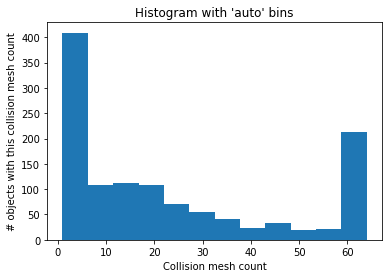

15.0
35.53453947368421
87.92128165325545


In [11]:
import matplotlib.pyplot as plt
a = np.array(list(o_directives.values()))
_ = plt.hist(np.minimum(a, 64), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel("Collision mesh count")
plt.ylabel("# objects with this collision mesh count")
plt.show()
print(np.median(a))
print(np.mean(a))
print(np.std(a))

In [24]:
import sys
sys.path.append(r"D:\ig_pipeline")
from b1k_pipeline.utils import get_targets, PIPELINE_ROOT, parse_name

In [89]:
import json
from collections import defaultdict
# Count the number of objects with non-tagged fixed links
link_cnts = {}
for target in tqdm.tqdm(get_targets("combined")):
    obj_list_file = PIPELINE_ROOT / "cad" / target / "artifacts" / "object_list.json"
    assert obj_list_file.exists(), "Missing obj list file " + str(obj_list_file)
    with open(obj_list_file, "r") as f:
        data = json.load(f)
        meshes = data["meshes"]
        parsed = [parse_name(x) for x in meshes]
        obj_link_cnts = defaultdict(set)
        for p in parsed:
            if not p.group("link_name") or p.group("link_name") == "base_link":
                continue
            if p.group("bad"):
                continue
            obj_name = p.group("obj_basename")
            link_name = p.group("link_basename")
            # Don't count openable links
            if p.group("tag") and "openable" in p.group("tag"):
                continue
            obj_link_cnts[obj_name].add(link_name)
        # fixed = sum(1 for x in parsed if x is not None and x.group("joint_type") == "F" and not x.group("tag"))
        link_cnts.update({x: len(y) for x, y in obj_link_cnts.items()})

100%|████████████████████████████████████████████████████████████████████████████| 1232/1232 [00:00<00:00, 4467.26it/s]


Interesting count:  35


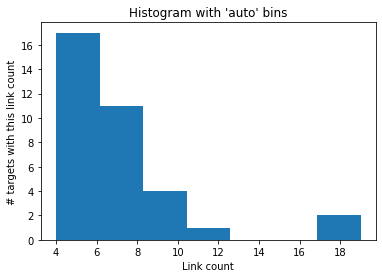

In [90]:
interesting = np.asarray(list(link_cnts.values()), dtype=int)
interesting = interesting[interesting>3]
print("Interesting count: ", len(interesting))
_ = plt.hist(interesting, bins="auto")  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel("Link count")
plt.ylabel("# targets with this link count")
plt.show()

In [91]:
print("\n".join(str(x) for x in sorted(link_cnts.items(), key=lambda x: -x[1])))

('microwave-abzvij-0', 19)
('microwave-bfbeeb-0', 18)
('washer-omeuop-0', 12)
('dryer-xsuyua-0', 10)
('coffee_maker-pyttso-0', 9)
('stove-qbjiva-0', 9)
('stove-rgpphy-0', 9)
('breakfast_table-rjgmmy-0', 8)
('coffee_table-fqluyq-0', 8)
('coffee_table-qlmqyy-0', 8)
('desk-ampuyz-0', 8)
('desk-yezrwt-0', 8)
('dryer-zlmnfg-0', 8)
('washer-xusefg-0', 8)
('desk-bptvoy-0', 7)
('dryer-fhtvuq-0', 7)
('stove-igwqpj-0', 7)
('stove-yhjzwg-0', 7)
('pedestal_table-pyybeq-0', 6)
('stove-dusebh-0', 6)
('stove-dwhqap-0', 6)
('monitor-huvcgu-0', 5)
('table_lamp-zpqejt-0', 5)
('coffee_table-elhvfw-0', 4)
('coffee_table-gcollb-0', 4)
('console_table-fihyuz-0', 4)
('desk-kmmlna-0', 4)
('dishwasher-tnlzww-0', 4)
('microwave-hjjxmi-0', 4)
('stove-jhyhag-0', 4)
('stove-kfhkqp-0', 4)
('table_lamp-kwkqot-0', 4)
('table_lamp-pmekkr-0', 4)
('washer-jgyzhv-0', 4)
('washer-zgzvcv-0', 4)
('briefcase-rxvbea-0', 3)
('coffee_table-aoojzy-0', 3)
('console_table-xqlxni-0', 3)
('desk-egzdgz-0', 3)
('desk-ntezkg-0', 3)
('d